
Our goal here is to find the prediction model with lowest RMSE. Let's have fun in adjusting parameters!

 # 1. Data Processing

In [1]:
#import package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## 1.1  Delete useless columns
There ae so many columns in the data, however, it's impossible to include all of them into the model. So.. The first step would be manually drop the columns which is obviously meaningless: like URL,ID numbers. In fact, there are still plenty of information like 'require license?','host_since', which we have no idea  about their relationship with pricing yet. However, I think it's fine to remain them in the data set at this moment. *

In [2]:
list_df = pd.read_csv('listings.csv')
list_df.head()
# Manually drop some columns that are useless
dropcol=['listing_url','scrape_id','jurisdiction_names','license','thumbnail_url','medium_url','picture_url','xl_picture_url'
        ,'host_thumbnail_url','host_picture_url','neighbourhood_group_cleansed']
list_df.drop(dropcol, axis=1, inplace=True)

In [6]:
list_df.shape

(3585, 84)

## 1.2 Missing data
There are two criterion for it:
    1. The column has more than 20% of the data is missing
    2. The column is less important to our target feature: Price
If column meet both of criterion, just drop it!  It could be tough to determine whether the column is important or not.Personally, I make this descion by my prior knowledge on house pricing problem.

In [3]:
#Create a missing value summary table
total = list_df.isnull().sum().sort_values(ascending=False)
percent = (list_df.isnull().sum()/list_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
has_availability,3585,1.000000
square_feet,3529,0.984379
monthly_price,2697,0.752301
weekly_price,2693,0.751185
security_deposit,2243,0.625662
notes,1975,0.550907
interaction,1554,0.433473
access,1489,0.415342
neighborhood_overview,1415,0.394700
host_about,1309,0.365132


In [4]:
# Drop columns base on former criterion
missing= ['has_availability','square_feet','monthly_price','weekly_price','security_deposit','notes','interaction',
          'access','neighborhood_overview','host_about','transit','house_rules']
list_df.drop(missing, axis=1, inplace=True)

## 1.3 Change data type

The most annoyng and time-consuming part of data processing!

In [6]:
# Fix some datatype errors, extract numbers and change to int type
cols = ['host_response_rate', 'host_acceptance_rate', 'price', 'cleaning_fee', 'extra_people']
for col in cols:
    list_df[col] = list_df[col].str.extract(r'(\d+)')
    list_df[col] = list_df[col].astype('float64').astype('Int64')
list_df.columns
# Extract the number of amenities 
list_df['n_amenities'] = list_df['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
list_df.drop('amenities', axis=1, inplace=True)
newlist= list_df.select_dtypes(include=['int', 'float'])
# Use Median to replace with NA
int_fillmean = lambda x: x.fillna(round(x.mean()))
newlist = newlist.apply(int_fillmean, axis=0)
newlist = newlist.drop(['id', 'host_id', 'latitude', 'longitude'], axis=1).astype(float)

# 2. Describle Analysis
## 2.1 'Price' data analysis

**Several Insights:**
* Mean is \$168. The price of Boston Airbnb is not cheap :( 
* Variance is pretty large(12523.80). Price fluctuates so widely.
* Deviate from the normal distribution.
* Have appreciable positive skewness.
* Show peakedness
* Some outliers (min = \$1, defintely impossible!) Need further Anomaly Detection.


In [7]:
# Summary 
def status(x) : 
    return pd.Series([x.count(),x.min(),x.quantile(.25),x.median(),
                      x.quantile(.75),x.mean(),x.max(),x.var(),x.std(),x.skew(),x.kurt()],
                     index=['Size','MIN','25% quantile','Median','75% quantile','Mean','MAX','Var','STD','skew','kurt'])
summary=pd.DataFrame(round(status(list_df.price),2))
print(summary)

                     0
Size           3585.00
MIN               1.00
25% quantile     85.00
Median          150.00
75% quantile    220.00
Mean            168.51
MAX             999.00
Var           12523.80
STD             111.91
skew              1.78
kurt              5.47


/var/folders/v5/ls97yl7n7d5c_101lnk76gl00000gn/T/ipykernel_80168/2955574246.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list_df['price'])


Text(0.5, 0, 'Price (dollar)')

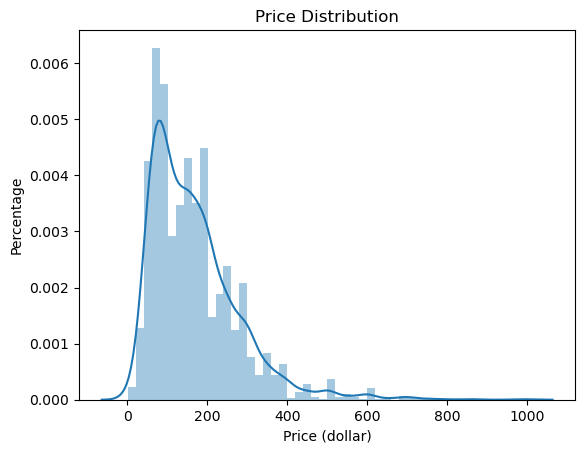

In [8]:
#histogram
sns.distplot(list_df['price'])
plt.title('Price Distribution', fontsize=12)
plt.ylabel('Percentage', fontsize=10)
plt.xlabel('Price (dollar)', fontsize=10)

## 2.2 Numberical variables Analysis



### 2.2.1 Heatmap for each numberical variables
1.Those features ae most positive correlated with price:
    * accommodates
    * beds
    * bedrooms
    * guest_include
    * cleaning fee
    * host_listing_count
    

2.There is another interesting finding, host accept rate has negative correlated with price to some degree which could be considered into our model.


3.The correlation between of host_listing_count and host_total_listing_count close to 1. We can drop one column for reducing dimension
   The same as availability_30/60/90. 

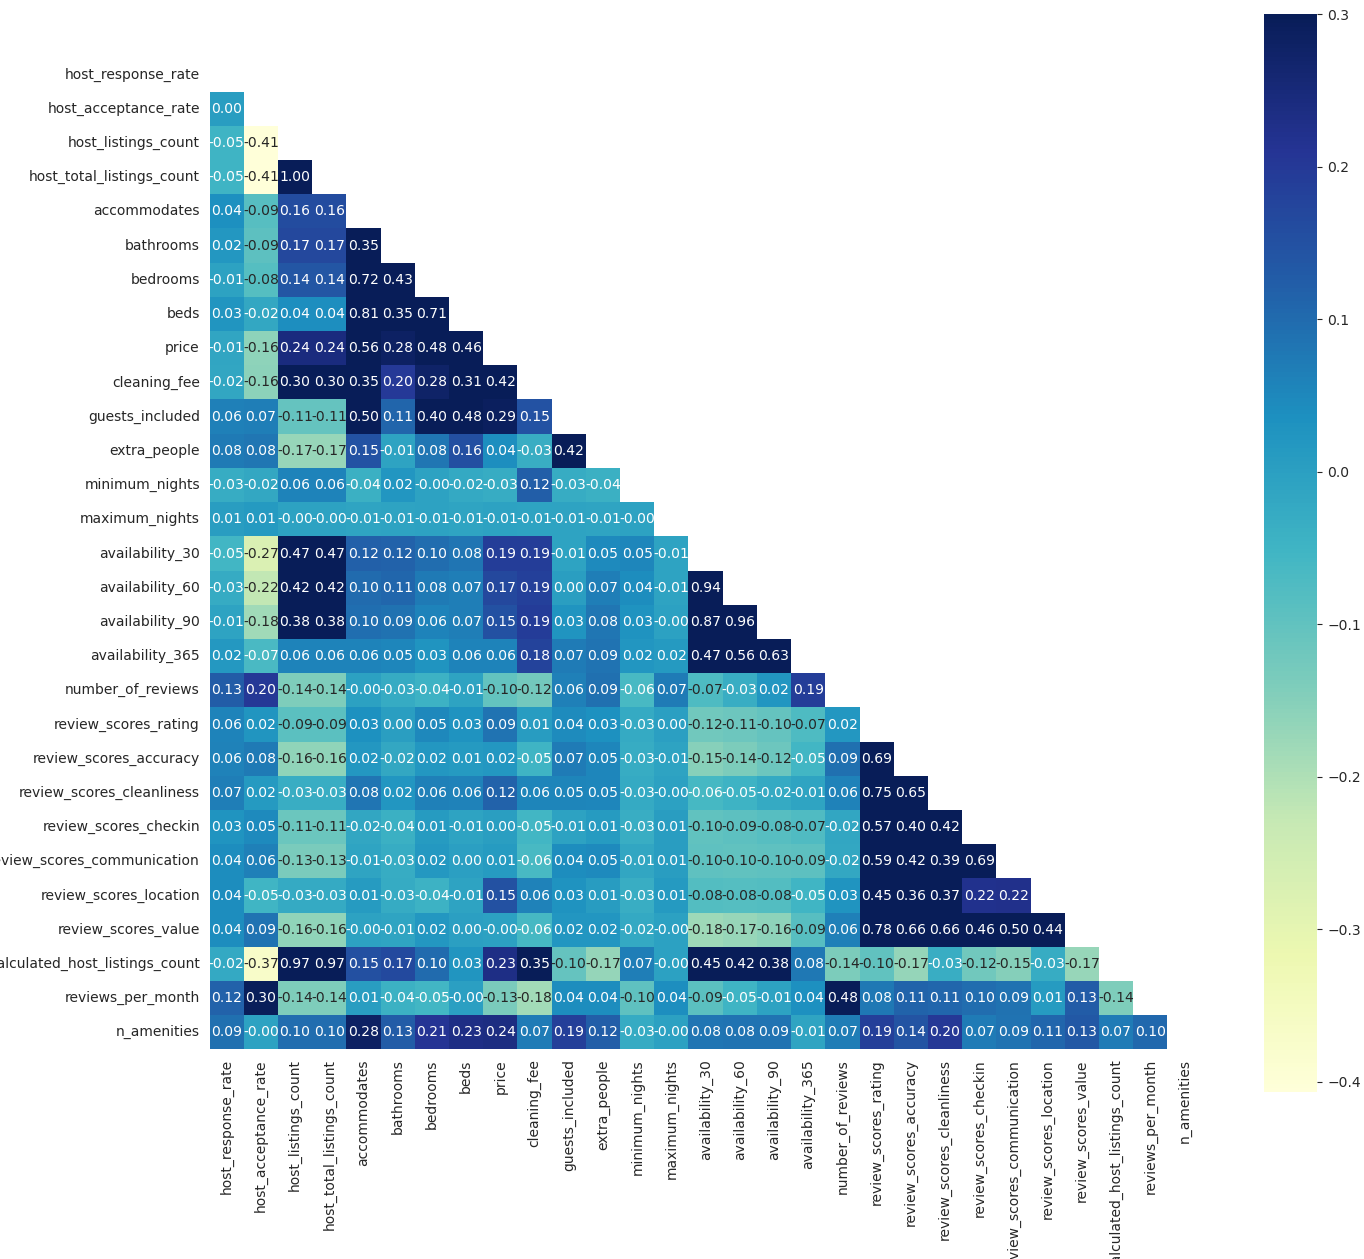

In [9]:
corr=newlist.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f',cmap='YlGnBu')



### 2.2.2 Boxplot for beds

Interesting! Zero bed has higher average than others! Basically, mean of beds follow rising trend. However, there's no big difference between beds of 3 to 5.

<Axes: xlabel='beds', ylabel='price'>

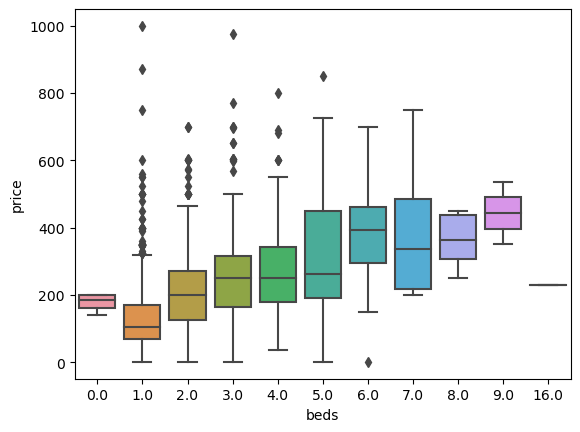

In [10]:
sns.boxplot(y='price', x='beds', data=list_df)

## 2.3 Text data analysis

In this part, I want to find the most popular words in title and description. 
* Not surprisingly, the high frequence words in title are location, room type and adjective words. 
* For description, common words are "close to","access to","located in", also displaying the location and convenience.

For future Airbnb host, it could be a reference for you to name your house! 


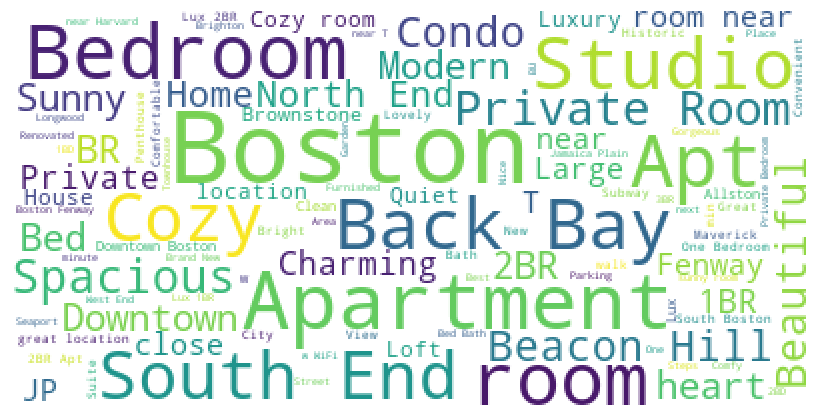

In [14]:
# Transform data structure
import string
p_words={}
words=list_df.loc[:,['name','price','description']]
words=words[words.price!=1]
words=words[words.price < (220+1.5*(220-85))]

##Key part!! Transform from list to string
def transfer(x):
    name=[]
    text=' '
    for i in range(len(x)):
        name += x.iloc[i].split(' ')
    for word in name:
        text +=word +' '
    return text
name=transfer(words.name)
description=transfer(words.description)
#Draw the plot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(name)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

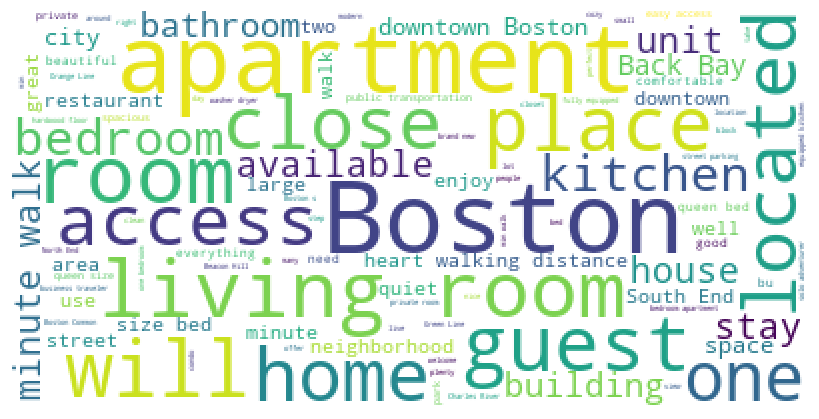

In [15]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(description)                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## 2.4 Categorical variables Analysis
### 2.4.1 Boxplot for neighbourhood

1. Not surprisingly, top 4 neighbourhoods are between the Financial District and Chinatown. Super near to south station. A great location for business person or tourists.
2. There are some outliers(extreme expensive) houses lie in Back Bay,Brighton, Mission hill.

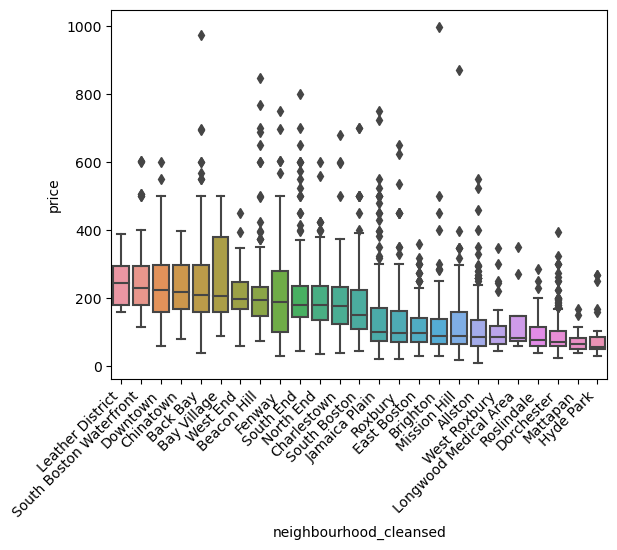

In [16]:
# Deal with outlier
list_df = list_df[list_df['price'] > 10] 
order_neigh=list_df.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
sns.boxplot(y=list_df.price, x=list_df.neighbourhood_cleansed,order=order_neigh)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### 2.4.2 Boxplot for property type

Mean price of Villa,Loft,Condo,Apartment are pretty close. However,there are many outliers in Apartment . Luxury Apartment may has a higher price,which could be a reasonable reason for it.

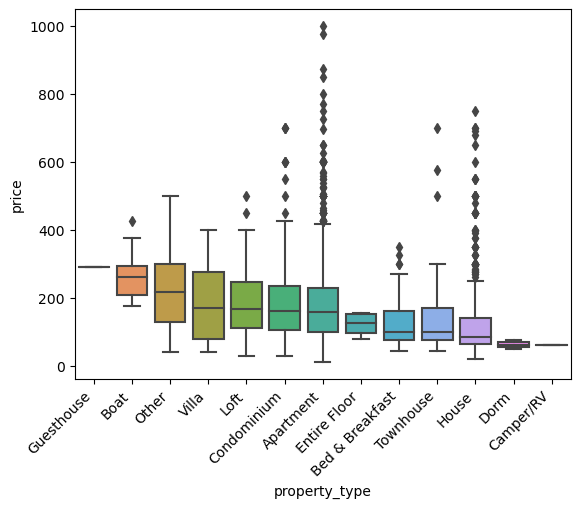

In [17]:
order_room_type=list_df.groupby('property_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y=list_df.price, x=list_df.property_type,order=order_room_type)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### 2.4.3 Boxplot for room type

Reasonable data. Entire room has higher price than share room.

<Axes: xlabel='room_type', ylabel='price'>

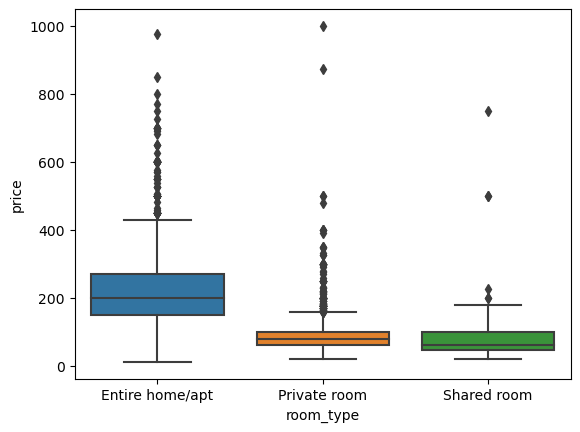

In [18]:
sns.boxplot(y='price', x='room_type', data=list_df)

### 2.4.4 Boxplot for bed type

Reasonable data. Real bed has higher price than others. 

<Axes: xlabel='bed_type', ylabel='price'>

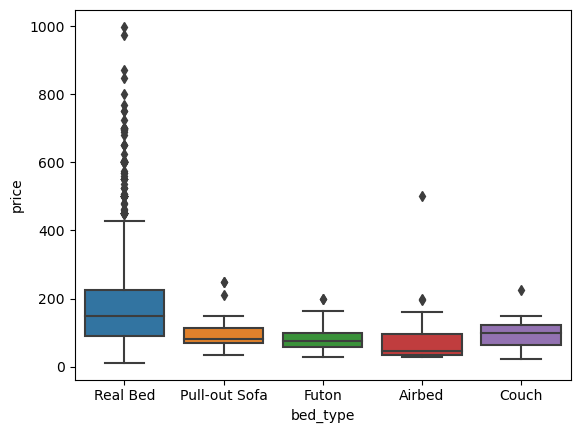

In [19]:
sns.boxplot(y='price', x='bed_type', data=list_df)

### 2.4.5 Boxplot for cancellation_policy

<Axes: xlabel='cancellation_policy', ylabel='price'>

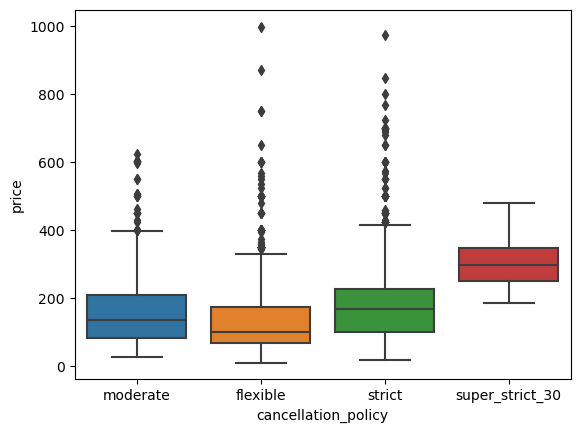

In [20]:
sns.boxplot(y='price', x='cancellation_policy', data=list_df)

# 3. Modeling
In this case, we have so many features and want to find a simple model to predict price problem. We'll introduce **Ridge regression**, which
is the first of two shrinkage methods. Then ,I’ll try the **lasso**, which is better but difficult to compute.



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn import preprocessing
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model

##### ### 3.1 Normalze, Split training and test set

As mentioned before, there are so many variables in the data. Personally, I only choose the top 15 numberical variables with highest correlation with Price and several categorical data.



In [22]:
#Deal with outliers

newlist = newlist[newlist['price'] >10]
newlist = newlist[newlist['price'] < (220+1.5*(220-85))]
list_df = list_df[list_df['price'] >10]
list_df = list_df[list_df['price'] < (220+1.5*(220-85))]

#Rank by correlation and only choose top 10  correlation.abs(),delete variables share high correlation with others
X = corr['price'].abs().sort_values(ascending=False).drop(['price','host_total_listings_count'])[:10]
x= newlist[X.index] 
y = newlist['price']

#Create dummy varaibles
dummy_room_type=pd.get_dummies(list_df['room_type'])
dummy_cancellation_policy=pd.get_dummies(list_df['cancellation_policy'])
dummy_bed_type=pd.get_dummies(list_df['bed_type'])
dummy_property_type=pd.get_dummies(list_df['property_type'])
dummy_neighbourhood_cleansed=pd.get_dummies(list_df['neighbourhood_cleansed'])
x=pd.concat([x,dummy_room_type,dummy_cancellation_policy,dummy_bed_type,dummy_neighbourhood_cleansed], axis=1)

# Normalize all features
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

x=normalize(x)
y= (y-min(y))/(max(y)-min(y))

# split training and testing model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [23]:
x_train

,accommodates,bedrooms,beds,cleaning_fee,guests_included,bathrooms,host_listings_count,n_amenities,calculated_host_listings_count,availability_30,...,Mattapan,Mission Hill,North End,Roslindale,Roxbury,South Boston,South Boston Waterfront,South End,West End,West Roxbury
1921,0.066667,0.0,0.0625,0.271186,0.214286,0.166667,0.001335,0.433333,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1653,0.000000,0.2,0.0625,0.050847,0.071429,0.166667,0.001335,0.200000,0.000000,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1291,0.133333,0.2,0.1250,0.322034,0.071429,0.166667,0.002670,0.466667,0.007407,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,0.333333,0.4,0.1875,0.237288,0.071429,0.333333,0.001335,0.500000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1193,0.200000,0.4,0.1250,0.745763,0.071429,0.166667,0.069426,0.300000,0.362963,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,0.000000,0.2,0.0625,0.016949,0.071429,0.166667,0.006676,0.133333,0.029630,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1172,0.200000,0.2,0.1250,0.067797,0.142857,0.166667,0.049399,0.566667,0.140741,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1345,0.066667,0.2,0.0625,0.305085,0.071429,0.166667,0.484646,0.566667,0.422222,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
890,0.066667,0.2,0.0625,0.152542,0.071429,0.166667,0.008011,0.233333,0.014815,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_train

1921    0.514778
1653    0.071429
1291    0.293103
1285    0.711823
1193    0.527094
          ...   
1137    0.305419
1172    0.502463
1345    0.487685
890     0.133005
3296    0.243842
Name: price, Length: 2422, dtype: float64

### 3.2 Ridge regression

As heatmap shows before, our variables are correlated to each other to some degree. Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors. It is hoped that the net effect will be to give estimates that are more reliable. We can use the alpha value to impose a maximum value on the sum of all our weight. By imposing this penalty, we can decrease unimportant parameters. 


The key step of Ridge regression is to choosing suitable alpha. The metrics we use here is RMSE(Root Mean Square Error)

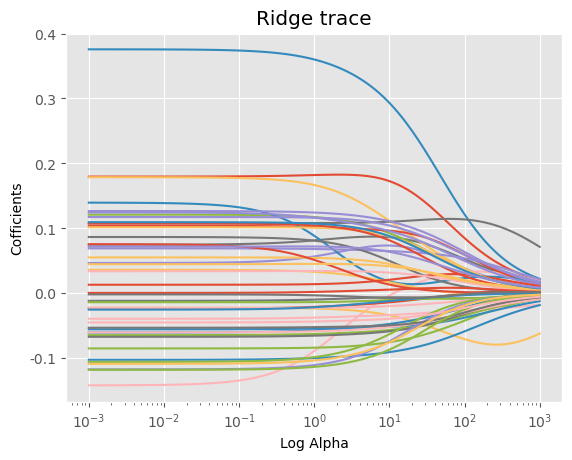

In [30]:
alphas = 10**np.linspace(-3,3,100)
from sklearn.metrics import mean_squared_error
ridge_cofficients = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train)
    ridge_cofficients.append(ridge.coef_)
    
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
plt.plot(alphas, ridge_cofficients)
plt.xscale('log')
plt.axis('tight')
plt.title('Ridge trace')
plt.xlabel('Log Alpha')
plt.ylabel('Cofficients')
plt.show()    

On the right side, the coefficients are all zero. Somewhere in the middle, we have some coefficient values that will give you better prediction results. To find satisfactory answers, we’d need to do **cross-validation testing.**

BTW..We could change scorng by different metrics. 

In [32]:
# coss-validation test
ridge_cv = RidgeCV(alphas = alphas, cv = 10,scoring="neg_mean_squared_error")
ridge_cv.fit(x_train, y_train)
# best lambda
ridge_cv.alpha_

1.873817422860385

Use best alpha to build model. Our final result is show below.

In [33]:
model_ridge=Ridge(alpha = ridge_cv.alpha_)
model_ridge.fit(x_train,y_train)
pred_ridge= model_ridge.predict(x_test)

# evaluate the result
rmse = np.sqrt(metrics.mean_squared_error(y_test,pred_ridge))
r_square = metrics.r2_score(y_test, pred_ridge)
print('For test data set our final result is:')
print('RMSE {}'.format(rmse ))
print('R^2 is {}'.format(r_square))

For test data set our final result is:
RMSE 0.12334693804207439
R^2 is 0.6729063270045486


Let's visualize our result! To see how R^2 and RMSE change with aphla.

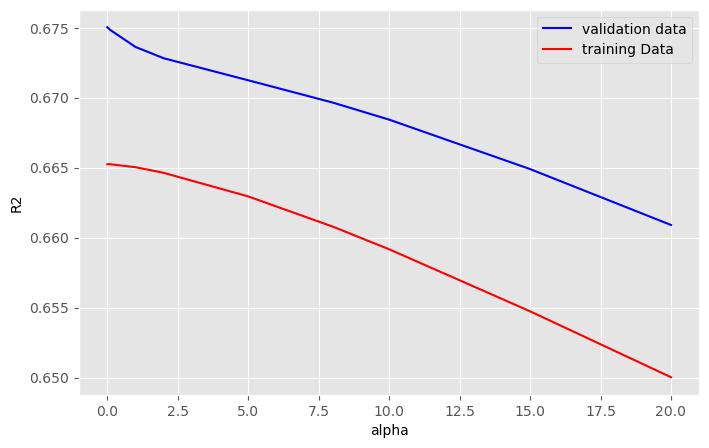

In [34]:
RR_square = []
RR_train = []
alpha = [0.0001, 0.001, 0.1, 1, 2,5,8,10, 15,20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(x_train, y_train)
    RR_square.append(RigeModel.score(x_test, y_test))
    RR_train.append(RigeModel.score(x_train, y_train))
    
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RR_square,'b' ,label='validation data')
plt.plot(alpha,RR_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.legend();

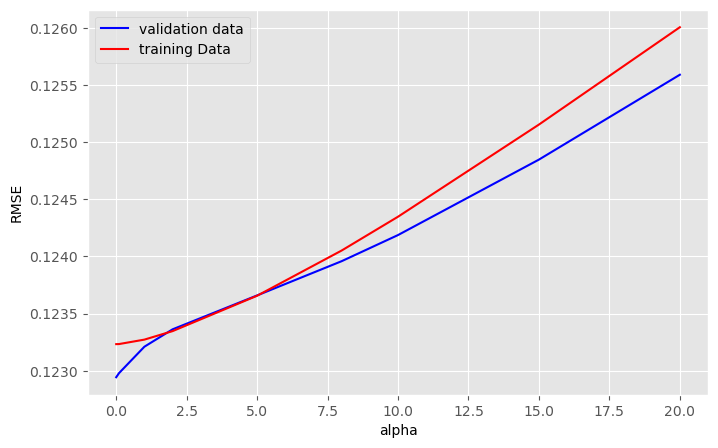

In [35]:
RMSE_valid = []
RMSE_train = []
alpha = [0.0001, 0.001, 0.1, 1, 2,5,8,10, 15,20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(x_train, y_train)
    RMSE_valid.append(np.sqrt(mean_squared_error(y_test, RigeModel.predict(x_test))))
    RMSE_train.append(np.sqrt(mean_squared_error( y_train, RigeModel.predict(x_train))))    
    
    
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RMSE_valid,'b' ,label='validation data')
plt.plot(alpha,RMSE_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend();

Visualize model prediction

/var/folders/v5/ls97yl7n7d5c_101lnk76gl00000gn/T/ipykernel_80168/1248808775.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
/var/folders/v5/ls97yl7n7d5c_101lnk76gl00000gn/T/ipykernel_80168/1248808775.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed29744

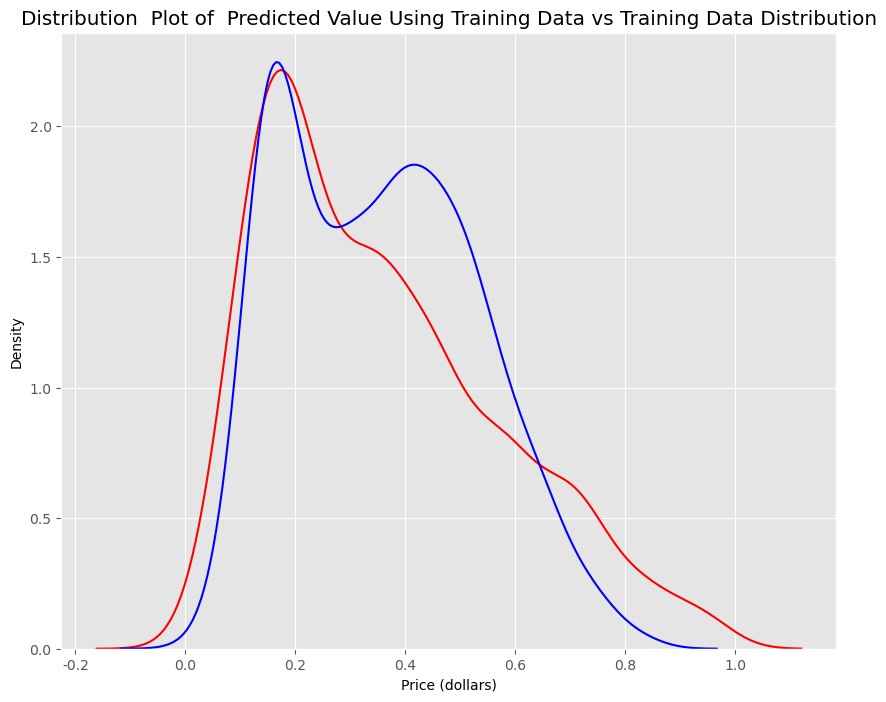

In [36]:
#Visualize model prediction
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    plt.figure(figsize=(10, 8))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()
DistributionPlot(y_test, pred_ridge, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

<Axes: xlabel='preds', ylabel='residuals'>

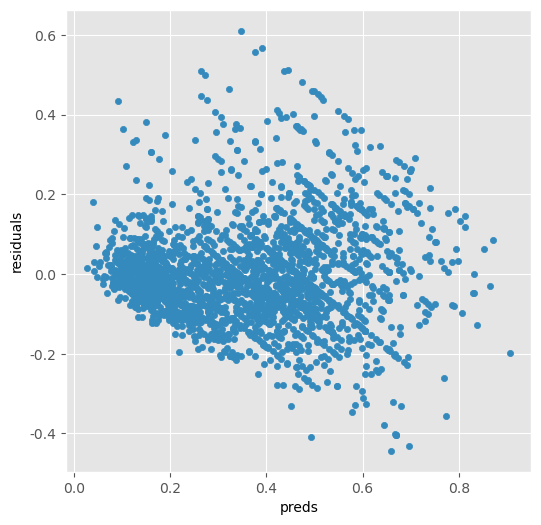

In [37]:
# residual scatter plot
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [38]:
np.corrcoef(model_ridge.predict(x_train),y_train)

array([[1.        , 0.81533001],
       [0.81533001, 1.        ]])